# Assignment 4

## Instructions
<ul>
    <li> Ensure that this assignment is your own work. PLagiarism will not be tolerated </li>
    <li> Ensure that all cells of this notebook run without error when run in order </li>
    <li> Follow the late day policy. Submit assignments on time </li>
    <li> Provide clear explanation for the algorithms you implement </li>
</ul>
Date released: 26/10/2020 

Due date: 01/11/2020 

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

---
## 4.1
### Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [1]:
%matplotlib tk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_points = []
fig = plt.figure(figsize=(20,30))

img=mpimg.imread('Images/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

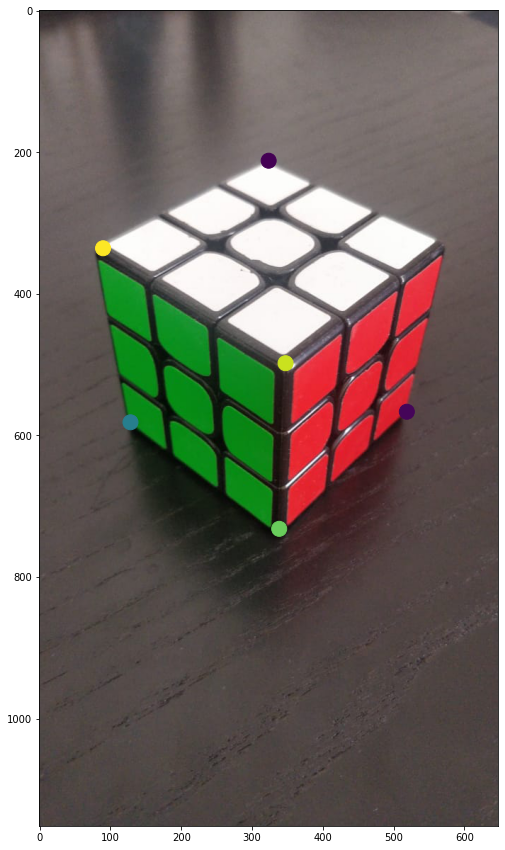

In [2]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [3]:
#We'll rename image_points to x to match textbook convention
x = image_points
# X represents the 3D world points
X = []
#Add your points here
#Add them as 3D points only
# X.append([1,0,0])
X.append([0, 4, 0])
X.append([0, 0, 0])
X.append([4, 0, 0])
X.append([4, 4, 4])
X.append([0, 4, 4])
X.append([0, 0, 4])
X = np.array(X)

Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [4]:
#Helper functions
#appends a ones column to input
def hom_coords(x,X):
    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate(
        (x,ones),
        axis = 1)
    X = np.concatenate(
        (X,ones),
        axis = 1)
    return x, X

x,X = hom_coords(x,X)

print('x:', x.shape)
print('X:', X.shape)

x: (6, 3)
X: (6, 4)


#### Explanation

DLT, or Direct Linear Trasnsform solves the problem of estimating the camera calibration matrix for an uncalibrated camera, i.e., it estimates both the camera extrinsics and intrinsics (without separating them, in  its basic form).\
Given a world point $\mathbf{X}$ and the corresponding image point $\mathbf{x}$, they satisfy

$$
\begin{align}
\mathbf{x}_{3 \times 1} &= K_{3 \times 3}R_{3 \times 3}\left[I_{3 \times 3} \vert -\mathbf{t}_{3 \times 1} \right]\mathbf{X}_{4 \times 1} \\
\implies \mathbf{x}_{3 \times 1} &= P_{3 \times 4}\mathbf{X}_{4 \times 1}
\end{align}
$$

where $P$ is the camera calibration matrix. \
P has 11 unknowns: 3 rotations, 3 translations, $f_x$, $f_y$, $c$, $s$ and $m$ (or, alternatively, $P$ has 12 elements, and is homogenous, thereby leaving us with 11 parameters) that need to be estimated. \
We know that each point gives us 2 equations (one for $x$ and one for $y$), and hence we need a minimum of 6 points.

**Forming the equations:**\
We divide by the third and fourth coordinate in $\mathbf{x}$ and $\mathbf{X}$ respectively to get
$$
\begin{bmatrix}
x \\
y \\
1 \\
\end{bmatrix} = P
\begin{bmatrix}
X \\
Y \\
Z \\
1 \\
\end{bmatrix}
$$

The equations look like
$$
\begin{align}
x &= \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}} \\
y &= \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
\end{align}
$$

Because these equations are not in a form that can be directly solved for $P$, we convert them to such a form by collecting all elements of $P$ in a vector and the other terms in a matrix.

$$
\mathbf{x_i} = 
\begin{bmatrix}
A^T \\
B^T \\
C^T \\
\end{bmatrix}
\mathbf{X}_i
$$
where $A^T, B^T, C^T$ are the rows of $P$.

Hence, the individual coordinates become,
$$
x_i = \frac{A^T \mathbf{X_i}}{C^T \mathbf{X_i}} \\
y_i = \frac{B^T \mathbf{X_i}}{C^T \mathbf{X_i}}
$$

which gives us,

$$
x_i C^T \mathbf{X_i} - A^T \mathbf{X_i} = 0 \\
y_i C^T \mathbf{X_i} - B^T \mathbf{X_i} = 0
$$

which is a system of linear equations in $A$, $B$ and $C$ and can be written as:
$$
\begin{bmatrix}
-X_i & -Y_i & -Z_i & -1 &
0 & 0 & 0 & 0 &
x_i X_i & x_i Y_i & x_i Z_i & x_i
\end{bmatrix}
\begin{bmatrix}
p_{11} \\
p_{12} \\
\vdots \\
p_{43} \\
\end{bmatrix}
=0 \\
\begin{bmatrix}
0 & 0 & 0 & 0 &
-X_i & -Y_i & -Z_i & -1 &
y_i X_i & y_i Y_i & y_i Z_i & y_i
\end{bmatrix}
\begin{bmatrix}
p_{11} \\
p_{12} \\
\vdots \\
p_{43} \\
\end{bmatrix}
=0
$$

We combine this, for all the 6 (or more) points, into

$$
A_{2n \times 12}\mathbf{p}_{12 \times 1} = \mathbf{0}
$$

Now, because of noise, $A$ would most likely be full rank and have a non-existent null space (i.e., no $\mathbf{p}$ would satisfy this for all points in $A$). Hence. we minimise $||A\mathbf{p}||_2^2$, subject to $||\mathbf{p}|| = 1$ to avoid trivial solutions. \
Thus, the DLT objective is
$$
p = argmin_{\mathbf{p}} \ \mathbf{p}^T A^T A\mathbf{p} \\
st \ ||\mathbf{p}|| = 1
$$

The solution to this being the right singular vector corresponding to the smallest singular value of $A$, which is the eigen vector corresponding to the smallest eigen value of $A^T A$.

To minimise the effect of noise, more than 6 points are usually used, and techniques such as RANdom SAmple Consensus might be employed to nullify the effect of outliers, to which DLT is otherwise very susceptible.

Thus, DLT provides a mapping from the world points to the camera points for an uncalibrated camera.

In [5]:
def get_m(img_points, wld_points):
    '''
    Takes in homogenous images points and 3D world points, rearranging them into the m matrix
    '''
    
    x = img_points[:, 0]
    y = img_points[:, 1]
    
    X = wld_points[:, 0]
    Y = wld_points[:, 1]
    Z = wld_points[:, 2]
    
    n = img_points.shape[0] # number of datapoints
    
    a_x = np.c_[-1*X, -1*Y, -1*Z, -1*np.ones(n), np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n), np.multiply(x, X), np.multiply(x, Y), np.multiply(x, Z), x]
    a_y = np.c_[np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n), -1*X, -1*Y, -1*Z, -1*np.ones(n), np.multiply(y, X), np.multiply(y, Y), np.multiply(y, Z), y]
    
    # Interleave
    out = np.empty((2 * n, a_x.shape[1]))
    out[::2, :] = a_x
    out[1::2, :] = a_y
    return out

#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
def DLT(x,X):
    """
    DLT without RANSAC
    """
    m = get_m(x, X)
    U, S, V = np.linalg.svd(m)
    P = V[-1, :].reshape((3, 4))
    return P

In [6]:
P = DLT(x, X)

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [7]:
#Get reprojected points
def get_points(P,X):
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    """
    find the MSE between reprojected points
    and x
    """
    #to err is to human
    diff = x[:, :2] - points
    err = np.linalg.norm(diff, axis=1)
    return np.mean(err ** 2)

print('P\n', P)
print('Reprojection Error:', get_err(image_points, X, P))

P
 [[ 7.92880863e-02 -6.11431629e-02 -1.82928426e-02  4.15395839e-01]
 [-2.41279186e-02 -3.06913894e-02 -1.01731986e-01  8.97335812e-01]
 [ 4.68810742e-05  2.68700233e-05 -5.99399764e-05  1.22559897e-03]]
Reprojection Error: 0.2795572933933855


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [8]:
def get_KRt(P):
    """
    """
    H = P[:, :3]
    h = P[:, -1]
    H_inv = np.linalg.pinv(H)
    
    t = - H_inv @ h
    
    R_tr, K_inv = np.linalg.qr(H_inv)
    R = R_tr.T
    K = np.linalg.pinv(K_inv)
    K = K / K[-1, -1]
    
    return K, R, t

K, R, t = get_KRt(P)
print('K\n', K)
print('R\n', R)
print('t:', t)

K
 [[ 1.16321806e+03  2.47571587e+01  4.86848328e+02]
 [ 1.09006038e-13 -1.19107658e+03  6.35993319e+02]
 [ 3.65221790e-13  1.93911179e-13  1.00000000e+00]]
R
 [[-0.58955201  0.80127561 -0.10191091]
 [-0.56120931 -0.49708776 -0.66177629]
 [-0.58092386 -0.33295819  0.74274242]]
t: [-7.01115492 -5.97358138 12.28559424]


Reproject the world points with P matrix you have obtained via DLT:

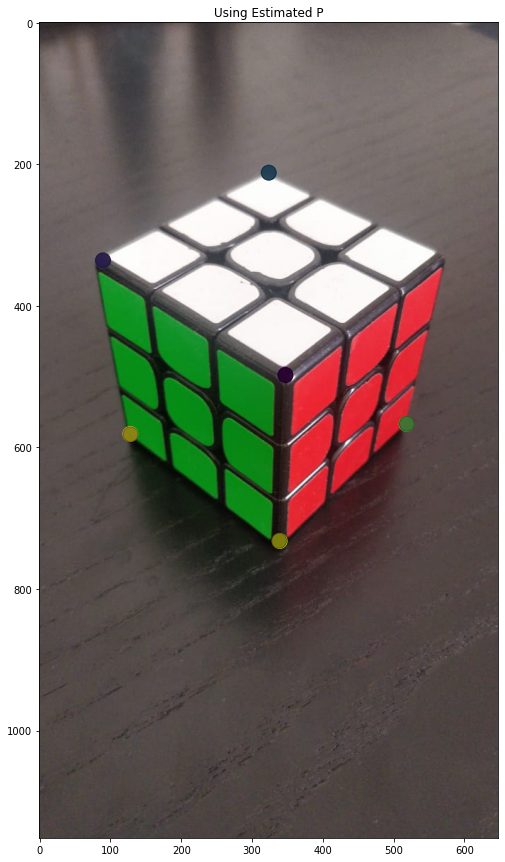

In [9]:
%matplotlib inline

re_proj = get_points(P, X)
N = re_proj.shape[0]
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(re_proj[:,0], re_proj[:,1], c=colors, s=area, alpha=0.9)
plt.scatter(image_points[:, 0], image_points[:, 1], c='black', s=area, alpha=0.4)
plt.title('Using Estimated P')
plt.show()

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in images/zhangs folder for this task. Familiarize yourself with the different parameters for this method.

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

Here we were given 15 images of chessboards which were taken by a  static camera by moving chessboard. Using those images we need to detect camera matrix using Zhangs method. First we converted image to gray scale and then find the corner points on chessboard (which are points where two black squares intersects) using *cv2.findChessboardCorners* function. There are total $6*8$ such points as we can see in given images. After this if this method is able to detect points(it is possible that it can't detect corners maybe when image is not that good) then we increase accuracy of detected points using *cv2.cornerSubPix* function. Finally we draw points on image for visualization using cv2.drawChessboardCorners function.

At this point we have corresonding $2D$ and $3D$ points of chessboard which we finally used to measure our Camera Matrix using *cv2.calibrateCamera* function

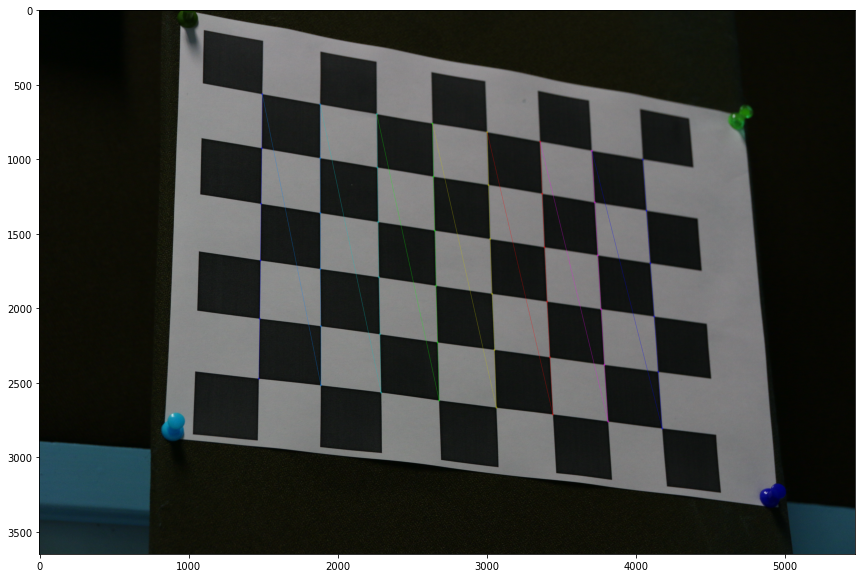

In [3]:
ROWS, COLS = 6, 8

obj = np.zeros((COLS * ROWS,3),np.float32)
obj[:,:2] = np.mgrid[0:ROWS, 0:COLS].T.reshape(-1,2)

obj_points = [] 
img_points = [] 

plt.figure(figsize=(20,10))
PATH = 'Images/Zhangs/'

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for img_name in sorted(os.listdir(PATH)):    
    img_name = os.path.join(PATH, img_name)
    img = cv2.imread(img_name)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, crnrs = cv2.findChessboardCorners(gray, (ROWS, COLS))
    
    if ret:
        obj_points.append(obj)
        
        window_size = (11, 11)
        zero_zone = (-1, -1)
        crnrs = cv2.cornerSubPix(gray, crnrs, window_size, zero_zone, criteria)
        img_points.append(crnrs)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (ROWS,COLS), crnrs, True)
        plt.imshow(img)

In [4]:
K = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1],None,None)[1]
# K matrix of camera
print(K)

[[1.36415093e+04 0.00000000e+00 3.31635835e+03]
 [0.00000000e+00 1.36632517e+04 1.50037365e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


---
## 4.2
### Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. The fundamental matrix that encodes their relative geometry as well as a subset of corresponding points have been provided to you. The images are in q2 folder.

Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image.

In [15]:
data_file = "q2/data.txt"

with open(data_file, 'r') as f:
    A = f.readlines()
    
img_points1 = A[2:12]
img_points1 = [i.strip()[:-1] for i in img_points1]
img_points1[0] = img_points1[0][1:]
img_points2 = A[15:25]
img_points2 = [i.strip()[:-1] for i in img_points2]
img_points2[0] = img_points2[0][1:]

F_mat = A[28:31]
F_mat = [i.strip()[:-1] for i in F_mat]
F_mat[0] = F_mat[0][1:]

img_1 = []
img_2 = []
F_MAT = []

for i in img_points1:
    img_1.append(np.fromstring(i[1:-1], sep=' '))
    
for i in img_points2:
    img_2.append(np.fromstring(i[1:-1], sep=' '))
    
for i in F_mat:
    F_MAT.append(np.fromstring(i[1:-1], sep=' '))

img_1 = np.array(img_1)
img_2 = np.array(img_2)
F_mat = np.array(F_MAT)

Provide a clear explanation on your approach for both this task and the next:

Equation of epipolar line corresponding to points of first image on second image is: $ F   X $  where $X$ represents points on first image and $F$ is Fundamental Matrix such that $x'^{T}Fx$ where $x'$ is the location of the point in the second image.                 

Here all coordinates are *Homogenous Coordinates* and Fundamental matrix is a $3*3$ matrix. So line equation we get after multiplying $F$ and $X$ is a $3*1$ matrix which can be represented as $ ax + by + c = 0 $ in *Euclidian Coordinates system*.                                    

By this way we got the equation of epipolar line and now to plot that line on image we used *cv2* line function which accepts two coordinates passing through the line and plots line on image. To find coordinates passing though the line:          
* $ x = 0 $ and calculate $y$ from line equation which comes out to be:  $ -c/b $
* $ x = x\_max $ here $ x\_max $ represents maximum $x$ coordinate of image i.e *img.shape[1]* and calculate $y$ from line equation which comes out to be:  $ -(c + a*x)/b $

By this way we plot epipolar lines on images and to plot points on image we used *cv2* circle function which accepts coordinates of points which were already given in the dataset.

By the same way we plotted epipolar line on first image, its equation is: $ F^T   X' $  where $F^T$ is tranpose of $F$ (Fundamental Matrix) and $X'$ corresponds to points on second image.

In [16]:
def epipolar_lines(img1_name,img2_name, points1, points2, F):
    img1 = plt.imread(img1_name)
    img2 = plt.imread(img2_name)
    x_max = img1.shape[1]

    for i in range(points1.shape[0]):
        # making homogenous coordinates
        point_arr = np.array([points1[i][0], points1[i][1], 1])        
        line = F @ point_arr
        # ax + by + c = 0
        a = line[0]; b = line[1]; c = line[2]
        x1, y1 = [0, int(-c / b) ] 
        x2, y2 = [x_max, int(-(c + a * x_max) / b) ]
        color = [np.random.randint(1, 255), np.random.randint(1, 255), np.random.randint(1, 255)]
        thickness_line = 4
        thickness_point = 10
        img1 = cv2.line(img1, (x1, y1), (x2, y2), color, thickness_line) 
        img1 = cv2.circle(img1, (int(points2[i][0]), int(points2[i][1])), thickness_point, color, -1)
        img2 = cv2.circle(img2, (int(points1[i][0]), int(points1[i][1])), thickness_point, color, -1)
        
    return img1, img2

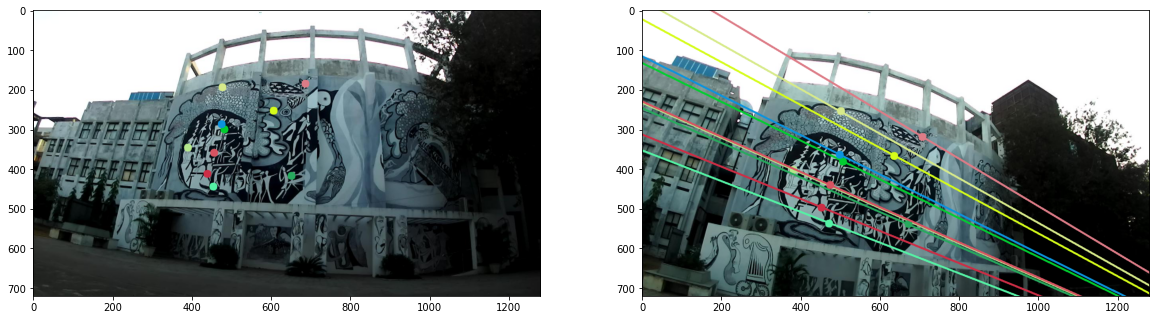

In [17]:
%matplotlib inline
H, W = 10, 10
ROWS, COLS = 1, 2
fig, ax = plt.subplots(ROWS, COLS, figsize = (H * COLS, H * ROWS)) 
ax = np.reshape(ax, (-1,))
img1, img2 = epipolar_lines('q2/img1.jpg','q2/img2.jpg', img_2, img_1, F_mat.T)
ax[0].imshow(img2)
ax[1].imshow(img1)

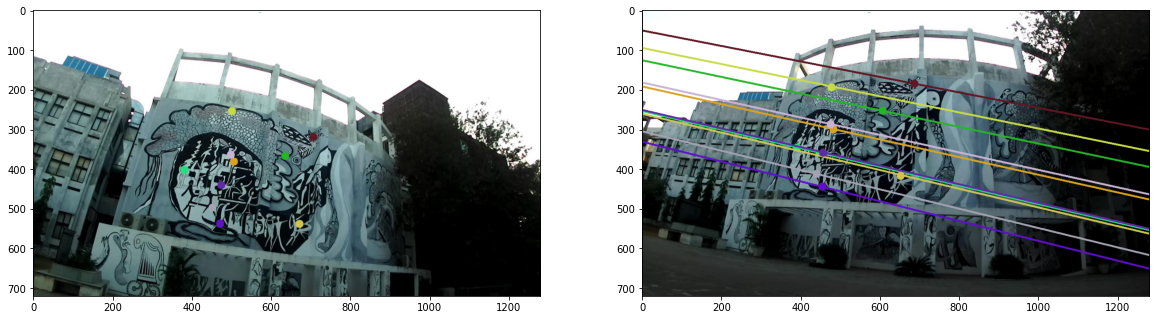

In [18]:
%matplotlib inline
H, W = 10, 10
ROWS, COLS = 1, 2
fig, ax = plt.subplots(ROWS, COLS, figsize = (H * COLS, H * ROWS)) 
ax = np.reshape(ax, (-1,))
img1, img2 = epipolar_lines('q2/img2.jpg','q2/img1.jpg', img_1, img_2, F_mat)
ax[0].imshow(img2)
ax[1].imshow(img1)

#### Task 2
Report the location of the epipoles.

We know that $ x' F x = 0 $ where $F$ is Fundamental Matrix, is satisfied for all corresponding points on first image and second image, here $x$ is point on first image and $x'$ is point on second image. And we also know that all epipolar lines on an image passes through the epipole of that image so if $X'\_ep$ is epipole on second image then for all points $x$ on first image $ X'\_ep \space F \space x = 0 $ this is satisfied because we saw above that $F x$ represents epipolar line on second image corresponding to point $x$ on first image and we also know that all epipolar lines passes through the epipole so epipole will satisfy the line equation $X'\_ep\space L = 0$ here L is equation of epipolar line.     

So from $ X'\_ep \space F \space x = 0 $ we can infer that epipole is null space of Fundamental Matrix.

According to our convention F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image.

* Epipole of first image = $nullspace(F^T)$
* Epipole of second image = $nullspace(F)$

In [19]:
def nullspace(A):
    atol=1e-13
    rtol=0
    A = np.atleast_2d(A)
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    return vh[nnz:].conj().T

In [20]:
# Epipole of first image
epipole = nullspace(F_mat.T)
# converting homogenous coordinates to euclidian coordinates
print("Epipoles onf first image:",epipole[0]/epipole[2], epipole[1]/epipole[2])

Epipoles onf first image: [-5131.90963838] [-948.85463066]


In [21]:
# Epipole of second image
epipole = nullspace(F_mat)
# converting homogenous coordinates to euclidian coordinates
print("Epipoles onf second image:",epipole[0]/epipole[2], epipole[1]/epipole[2])

Epipoles onf second image: [2159.16628306] [1189.26810028]
